In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import RidgeCV, ElasticNet, ElasticNetCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn.model_selection import KFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

import mlxtend
from mlxtend.regressor import StackingCVRegressor

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

## 1. Figure Out The Question 

We wish to predict the sale prices of houses using features having to do with square footage, neighborhood, etc. We use the Ames data set which consists of 80 features that we will use. The data is pretty mess as we will find out. 

## 2. Obtain a Labeled Data Set 

Below we read in the labeled dataset and the unlabeled set -- out train and test sets respectively. We will have to clean the data quite a bit. Some of these ideas have been inspired from other kernels online but we notice that there are some outliars and missing values that ought to be considered. There are also a number of categorical variables that we ought to deal with effectively. 

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
print("Train size: {}".format(train.shape))
print("Test size:  {}".format(test.shape))

target = train.SalePrice # save in its own variable 

Train size: (1460, 81)
Test size:  (1459, 80)


In [3]:
# start to describe the data 
print("Train size: {}".format(train.shape))
print("\nTarget Data: ")
print(target.describe()) 

Train size: (1460, 81)

Target Data: 
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [4]:
train.head() # looking pretty nasty honestly 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
Id_train, Id_test = train.Id, test.Id # save ID's of specific houses 

### Note that the SalesPrice is pretty skewed. Lets log it to elininate the heteroskedasticity in hopes that it looks more normally distributed. That will be easier to work with. When we are done and making final predictions, we'll exponentiate it all. 

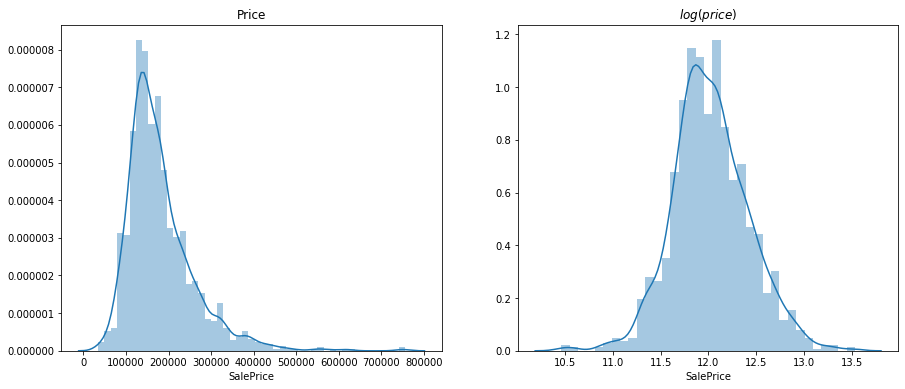

In [7]:
log_target = np.log(target)

plt.figure(figsize = (15, 6))

plt.subplot(121)
sns.distplot(target)
plt.title("Price")

plt.subplot(122)
sns.distplot(log_target)
plt.title("$log(price)$")

plt.show()

In [8]:
log_target.describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

### Look at the outliars here -- this isnt great. We'll see that this variable is STRONGLY correlated with SalesPrice so this is an important one to look at. We eliminate these variables since they will lever our lines of best fit negatively. 

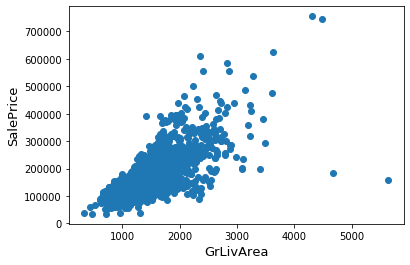

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = target)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [10]:
train = train.drop(train[(train['GrLivArea'] > 4500) & (target < 300000)].index)

In [11]:
# missing data put into a data-frame 
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageCond,81,0.055556
GarageType,81,0.055556
GarageYrBlt,81,0.055556
GarageFinish,81,0.055556


### Here are a lot of categorical variables that need to be dealt with. We want to keep the ones that are numeric numeric, and we want to be able to convert the others into dummy variables later on. I impute some missing values here too. 

In [12]:
train["PoolQC"], test["PoolQC"] = train["PoolQC"].fillna("None"), test["PoolQC"].fillna("None")

train["MiscFeature"], test["MiscFeature"] = train["MiscFeature"].fillna("None"), test["MiscFeature"].fillna("None")

train["Alley"], test["Alley"] = train["Alley"].fillna("None"), test["Alley"].fillna("None")

train["Fence"], test["Fence"] = train["Fence"].fillna("None"), test["Fence"].fillna("None")

train["FireplaceQu"], test["FireplaceQu"] = train["FireplaceQu"].fillna("None"), test["FireplaceQu"].fillna("None")

train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

test["MasVnrType"] = test["MasVnrType"].fillna("None")
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])

train = train.drop(['Utilities'], axis = 1)
test = test.drop(['Utilities'], axis = 1)

train["Functional"] = train["Functional"].fillna("Typ")
test["Functional"] = test["Functional"].fillna("Typ")

train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])

train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])

train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

train['MSSubClass'] = train['MSSubClass'].fillna("None")
test['MSSubClass'] = test['MSSubClass'].fillna("None")

In [13]:
for col in ["BsmtFinType2", "BsmtExposure", "BsmtFinType1", "BsmtCond", "BsmtQual"]: 
    train[col] = train[col].fillna("Typ")
    test[col] = test[col].fillna("Typ")

# train 
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
    
# test 
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    test[col] = test[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    test[col] = test[col].fillna(0)

### Here I create a new variable -- Total Square Feet -- and then create a square of that, adding both to the train and test sets. I drop the component variables to eliminate collinearities. 

In [14]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

train['TotalSFSQ'] = train['TotalSF'] * train['TotalSF']
test['TotalSFSQ'] = test['TotalSF'] * test['TotalSF']

train = train.drop(["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"], axis = 1)
test = test.drop(["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"], axis = 1)

### All of these Garage variables had the exact same amount of values missing as we saw in the DataFrame made earlier. This suggests something systematic in why they are missing which could skew the predictions. We thus eliminate them. 

In [15]:
train = train.drop(["GarageCond", "GarageType", "GarageYrBlt", "GarageFinish", "GarageQual"], axis = 1)
test = test.drop(["GarageCond", "GarageType", "GarageYrBlt", "GarageFinish", "GarageQual"], axis = 1)

In [16]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,TotalSFSQ
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,...,None,None,0,2,2008,WD,Normal,208500,2566,6584356
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,...,None,None,0,5,2007,WD,Normal,181500,2524,6370576
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,...,None,None,0,9,2008,WD,Normal,223500,2706,7322436
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,...,None,None,0,2,2006,WD,Abnorml,140000,2473,6115729
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,...,None,None,0,12,2008,WD,Normal,250000,3343,11175649


In [17]:
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(7)

,Total,Percent
TotalSFSQ,0,0.0
YearBuilt,0,0.0
RoofStyle,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0


In [18]:
train.shape, test.shape

((1458, 74), (1459, 73))

In [19]:
target = train["SalePrice"]
log_target = np.log(target)
train = train.drop(["SalePrice"], axis = 1)
target.shape, train.shape, test.shape

((1458,), (1458, 73), (1459, 73))

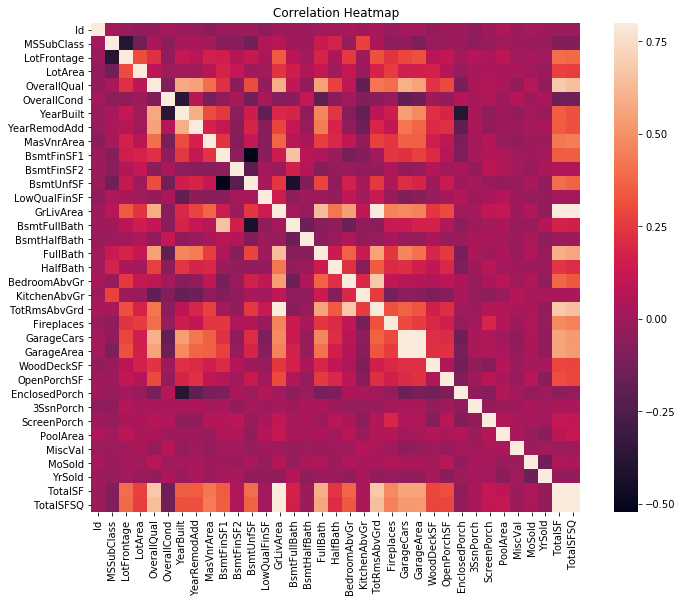

In [20]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.title("Correlation Heatmap")
plt.show()

In [21]:
Id_train, Id_test = train.Id, test.Id
train = train.drop(["Id"], axis = 1)
test = test.drop(["Id"], axis = 1)

test = pd.get_dummies(test, drop_first = True) 
train = pd.get_dummies(train, drop_first = True)
test.shape, train.shape

((1459, 221), (1458, 236))

### We dont have the same number of columns after getting_dummies. That's ok -- We find the difference between sets of the dataframes columns then eliminate the extra ones. Kind of ghetto but gets the job done. 

In [22]:
test_col = set(test.columns) 
train_col = set(train.columns) 
diff = train_col.difference(test_col) # find the difference between the train and test columns 

diff = list(set(train.columns).difference(set(test.columns))) # make a list of the differences 
train = train.drop(train[diff], axis = 1) # get rid of the extra train columns 

### Note that all the columns from the two dataframes are the same now!

In [23]:
print("All columns are the same: {}".format(all(train.columns == test.columns))) 

All columns are the same: True


In [24]:
# fill any straggling missing values with the means 

In [25]:
train, test = train.fillna(train.mean()), test.fillna(test.mean())        

## 3. Split Data into Train and Test Splits 

We do this below now that we've finally cleaned the data. We use k-fold cross validation with k = 10. We spit the train data into train and test splits. 

In [26]:
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 484)
X_train, X_test, y_train, y_test = train_test_split(train, log_target, test_size=0.33, random_state=42)

## 4 / 5. Choose an Appropriate Method to Use and Cross Validate

## 8. Do the Same for Various Models 

We start to test models and cross-validate them, using k = 10 folds and CV versions of the models. These are very useful for us. 

In [27]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [0.00008, 5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]

In [46]:
lasso = make_pipeline(RobustScaler(), LassoCV(alphas = [0.0005], cv = kfolds, random_state = 1))

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = alphas_alt, cv = kfolds))

en = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = 0.9, random_state = 3))


rf = RandomForestRegressor(**{'n_estimators': 600,
                              'min_samples_split': 2,
                              'min_samples_leaf': 1,
                              'max_features': 'sqrt',
                              'max_depth': None,
                              'bootstrap': False})

xgboost = XGBRegressor(learning_rate = 0.05, n_estimators = 730,
                       max_depth = 2, min_child_weight = 0,
                       objective = 'reg:squarederror', 
                       random_state = 1)

lgbr = LGBMRegressor(objective = 'regression', num_leaves = 5, 
                     learning_rate = 0.05, n_estimators = 550,
                     max_bin = 55, bagging_fraction = 0.8,
                     bagging_freq = 5, feature_fraction = 0.2319,
                     feature_fraction_seed = 9, bagging_seed = 9,
                     min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

# this stacking module cross-validates for us which is good
# but it takes a while to run 

stack = StackingCVRegressor(regressors = (lasso, en, lgbr, xgboost), 
                            meta_regressor = lgbr, 
                            use_features_in_secondary = True)

### Note the cross-validation scores. The parameters above in the models were chosen through a similar manner. 

In [30]:
scores = cross_validate(lasso, X_train, y_train, cv = kfolds)
print("LASSO scores: {}\n".format(scores["test_score"]))

scores = cross_validate(ridge, X_train, y_train, cv = kfolds)
print("RIDGE scores: {}\n".format(scores["test_score"]))

scores = cross_validate(rf, X_train, y_train, cv = kfolds)
print("Random Forest scores: {}\n".format(scores["test_score"]))

scores = cross_validate(xgboost, X_train, y_train, cv = kfolds)
print("XGBoost scores: {}\n".format(scores["test_score"]))

scores = cross_validate(lgbr, X_train, y_train, cv = kfolds)
print("LGBR scores: {}\n".format(scores["test_score"]))

LASSO scores: [0.92630447 0.8995566  0.94054683 0.92032308 0.93847402 0.94371911
 0.91449795 0.89623313 0.88818901 0.88675144]

RIDGE scores: [0.92545708 0.89399099 0.93914925 0.92179601 0.93648373 0.94092545
 0.91733835 0.8891826  0.8852116  0.88726443]

Random Forest scores: [0.88346759 0.87341254 0.91765413 0.90004174 0.88488146 0.92302813
 0.89417745 0.87132166 0.85329223 0.85869611]

XGBoost scores: [0.91027089 0.88158999 0.932819   0.92135239 0.92491362 0.93971038
 0.89544501 0.88704718 0.87023227 0.88175427]

LGBR scores: [0.92309501 0.88277274 0.93423177 0.92835659 0.91807318 0.93958013
 0.91402522 0.88750962 0.87967472 0.90019985]



## 6 / 7. Train Models on all of Train Data and Get Accuracy from y_test

In [47]:
models = [lasso, ridge, en, rf, xgboost, lgbr, stack]
names = ["Lasso", "Ridge", "Elastic Net", "Random Forest", "XGBoost", "LGBR", "Stacked"]

for model, name in zip(models, names): 
    
    model.fit(np.array(X_train), np.array(y_train)) 
    pred = model.predict(np.array(X_test))
    
    print("{} RMSE: {}".format(name, np.sqrt(mse(pred, y_test))))
    

Lasso RMSE: 0.11628248037543297
Ridge RMSE: 0.11673952828556516
Elastic Net RMSE: 0.11622428573293171
Random Forest RMSE: 0.13693093537716472
XGBoost RMSE: 0.11937765164230481
LGBR RMSE: 0.11838298364970704
Stacked RMSE: 0.12006873817095252


## 9. Train on all of Train Data and Predict with all Test Data

In [36]:
model = stack.fit(np.array(train), np.array(log_target))
predictions = model.predict(np.array(test)) 

In [37]:
submission = pd.DataFrame({"Id": Id_test, "SalePrice": np.exp(predictions)})
submission.to_csv("prices_final.csv", index = False)

In [ ]:
# final submission score on kaggle was 0.11986, placed 673/4590 (top 15%) 